In [1]:
import numpy as np
import pandas as pd

import random

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model
from keras.layers import Dropout, Activation

from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-13 09:27:48.205594: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 09:27:48.209376: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 09:27:48.259893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 09:27:49.248552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
df = pd.read_csv('/users/siru/Experminet/Notebooks/wkufinalddos.csv')

In [11]:
#analyze a DataFrame, particularly with 
#respect to the unique values and their distribution in each column
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [12]:
analyze(df)


1383863 rows
** timestamp:306648 (22%)
** datapath_id:[4:28.58%,3:27.47%,2:21.86%,5:12.72%,1:8.97%,6:0.4%]
** flow_id:339744 (24%)
** ip_src:270538 (19%)
** tp_src:63999 (4%)
** ip_dst:35080 (2%)
** tp_dst:16614 (1%)
** ip_proto:[6:43.52%,1:40.5%,17:15.8%,5:0.03%,3:0.03%,2:0.02%,4:0.02%,9:0.01%,7:0.01%,15:0.01%,8:0.01%,10:0.01%,13:0.01%,12:0.01%,16:0.01%,14:0.01%,11:0.01%]
** icmp_code:[-1:57.68%,0:42.32%]
** icmp_type:[-1:57.68%,8:31.16%,0:9.57%,4:0.23%,2:0.23%,3:0.23%,5:0.23%,1:0.22%,7:0.22%,6:0.22%]
** flow_duration_sec:101 (0%)
** flow_duration_nsec:335586 (24%)
** idle_timeout:[20:100.0%]
** hard_timeout:[100:100.0%]
** flags:[0:100.0%]
** packet_count:227243 (16%)
** byte_count:301965 (21%)
** packet_count_per_second:337057 (24%)
** packet_count_per_nsecond:368611 (26%)
** byte_count_per_second:338344 (24%)
** byte_count_per_nsecond:379457 (27%)
** label:[SLowloris-Attack:22.1%,TCP-SYN:18.86%,ICMP-Ping:15.42%,UDP-Flood:14.94%,DNS-Amplification:7.23%,NTP-Amplification:7.23%,LAND-

In [13]:
label_counts = df.groupby('label').size().reset_index(name='count')

# Display the result
print(label_counts)

               label   count
0             Benign   97933
1  DNS-Amplification  100000
2          ICMP-Ping  213388
3          LAND-DDOS   98988
4  NTP-Amplification  100000
5   SLowloris-Attack  305826
6            TCP-SYN  260963
7          UDP-Flood  206765


In [18]:
#drop na values and reset index
data_clean = df.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
data_clean['label'] = labelencoder.fit_transform(data_clean['label'])

data_clean['label'].value_counts()

label
5    305826
6    260963
2    213388
7    206765
1    100000
4    100000
3     98988
0     97933
Name: count, dtype: int64

In [15]:
print("columns: ", len(data_clean.columns))
data_clean.columns

columns:  23


Index(['index', 'timestamp', 'datapath_id', 'flow_id', 'ip_src', 'tp_src',
       'ip_dst', 'tp_dst', 'ip_proto', 'icmp_code', 'icmp_type',
       'flow_duration_sec', 'flow_duration_nsec', 'idle_timeout',
       'hard_timeout', 'flags', 'packet_count', 'byte_count',
       'packet_count_per_second', 'packet_count_per_nsecond',
       'byte_count_per_second', 'byte_count_per_nsecond', 'label'],
      dtype='object')

In [19]:
# Assuming the label is in the 23rd column (index 22)
data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

# Feature matrix X should include columns 1 to 21 (excluding the index and label)
X = data_np[:, 1:22]

# One-hot encoding for the label (assuming label is in the 23rd column)
enc = OneHotEncoder(sparse_output=False)
Y = enc.fit_transform(data_np[:, 22].reshape(-1, 1))

# Standard scaling for features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True
)

# Print dimensions
_features = X.shape[1]
n_classes = Y.shape[1]
print('X.shape = ', X.shape)
print('Y.shape = ', Y.shape)
print('X_train.shape = ', X_train.shape)
print('Y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('Y_test.shape = ', Y_test.shape)

X.shape =  (1383863, 21)
Y.shape =  (1383863, 8)
X_train.shape =  (1037897, 21)
Y_train.shape =  (1037897, 8)
X_test.shape =  (345966, 21)
Y_test.shape =  (345966, 8)


/users/siru/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 139s 17ms/step - accuracy: 0.9901 - loss: 0.1067 - val_accuracy: 0.9993 - val_loss: 0.0644
Epoch 2/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 131s 16ms/step - accuracy: 0.9960 - loss: 0.0814 - val_accuracy: 0.9995 - val_loss: 0.0609
Epoch 3/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 130s 16ms/step - accuracy: 0.9967 - loss: 0.0741 - val_accuracy: 0.9998 - val_loss: 0.0516
Epoch 4/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 130s 16ms/step - accuracy: 0.9970 - loss: 0.0697 - val_accuracy: 0.9995 - val_loss: 0.0524
Epoch 5/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 130s 16ms/step - accuracy: 0.9972 - loss: 0.0685 - val_accuracy: 0.9997 - val_loss: 0.0408
Epoch 6/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 130s 16ms/step - accuracy: 0.9971 - loss: 0.0680 - val_accuracy: 0.9998 - val_loss: 0.0512
Epoch 7/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 129s 16ms/step - accuracy: 0.9973 - loss: 0.0606 - val_accuracy: 0.9999 - val_loss: 0.0413
Epoch 8/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 130s 16ms/step - accuracy: 

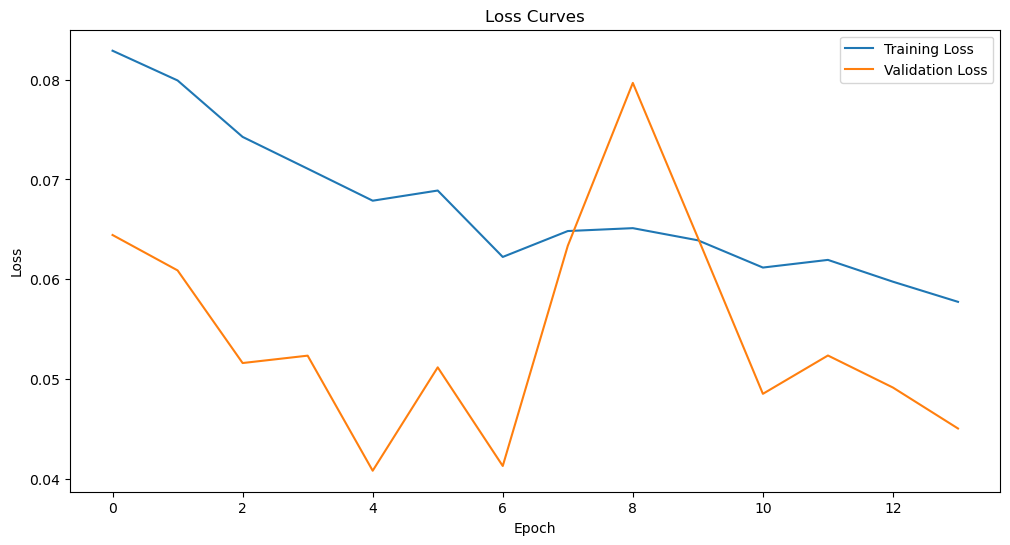

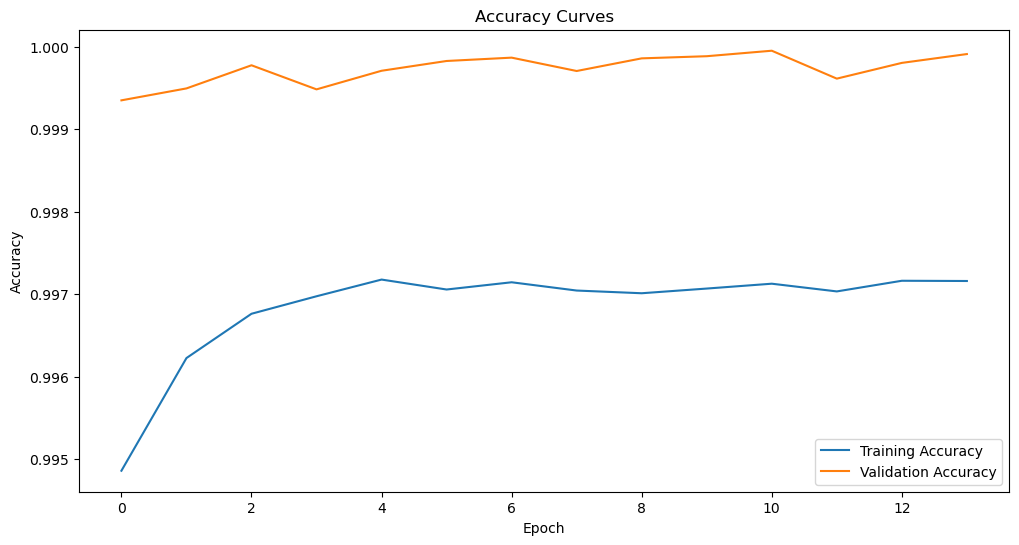

In [20]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the best hyperparameters
best_hyperparameters = {
    'conv1d_1_filters': 96,
    'l2_1': 0.0016168723737071179,
    'conv1d_2_filters': 96,
    'l2_2': 4.817500452374327e-06,
    'conv1d_3_filters': 128,
    'l2_3': 2.557674796721216e-06,
    'dense_1_units': 64,
    'l2_dense_1': 9.406669398810592e-06,
    'dropout_1': 0.5,
    'dense_2_units': 224,
    'l2_dense_2': 0.0044082252176780344,
    'dropout_2': 0.5,
    'learning_rate': 0.004224524015027432,
    'batch_size': 128
}
early_stop_callback = EarlyStopping(monitor='val_accuracy', patience=3)  # Customize settings as needed

# Build the model using the best hyperparameters
cnn = keras.Sequential()

# Convolutional layers with Batch Normalization
cnn.add(layers.Conv1D(filters=best_hyperparameters['conv1d_1_filters'],
                        kernel_size=6,
                        input_shape=(_features, 1),
                        kernel_regularizer=regularizers.l2(best_hyperparameters['l2_1'])))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPooling1D(pool_size=2))

cnn.add(layers.Conv1D(filters=best_hyperparameters['conv1d_2_filters'],
                        kernel_size=6,
                        padding='same',
                        kernel_regularizer=regularizers.l2(best_hyperparameters['l2_2'])))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPooling1D(pool_size=2))

cnn.add(layers.Conv1D(filters=best_hyperparameters['conv1d_3_filters'],
                        kernel_size=6,
                        padding='same',
                        kernel_regularizer=regularizers.l2(best_hyperparameters['l2_3'])))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPooling1D(pool_size=2))

# Flatten layer
cnn.add(layers.Flatten())

# Dense layers with Batch Normalization
cnn.add(layers.Dense(units=best_hyperparameters['dense_1_units'],
                       kernel_regularizer=regularizers.l2(best_hyperparameters['l2_dense_1'])))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.Dropout(best_hyperparameters['dropout_1']))

cnn.add(layers.Dense(units=best_hyperparameters['dense_2_units'],
                       kernel_regularizer=regularizers.l2(best_hyperparameters['l2_dense_2'])))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.Dropout(best_hyperparameters['dropout_2']))

# Output layer
cnn.add(layers.Dense(n_classes, activation='softmax'))

# Optimizer
opt = keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate'])

# Compile the model
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = cnn.fit(X_train, Y_train, epochs=15, batch_size=best_hyperparameters['batch_size'], 
                          validation_data=(X_test, Y_test), callbacks=[early_stop_callback])
test_loss, test_accuracy = cnn.evaluate(X_test, Y_test)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
cnn.save("CNNFINALVersion.h5")

In [38]:
cnn.save("CNNFINALVersion.keras")

In [41]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import numpy as np
from keras.models import load_model

start = dt.datetime.now()

# Load the saved model

# Assuming X_test and Y_test are already defined
escore = cnn.evaluate(X_test, Y_test, batch_size=128)
pred = cnn.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_eval = np.argmax(Y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_eval, pred_classes)

# Compute TP, TN, FP, FN for each class individually
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR) for each class
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# If you want overall FPR and FNR, you can average these values over all classes
overall_FPR = np.mean(FPR)
overall_FNR = np.mean(FNR)

score = accuracy_score(y_eval, pred_classes)
rscore = recall_score(y_eval, pred_classes, average='weighted')
ascore = precision_score(y_eval, pred_classes, average='weighted')
f1score = f1_score(y_eval, pred_classes, average='weighted')
roc_score = roc_auc_score(y_eval, pred, multi_class='ovo')

print('Completed')
print('Time taken:', dt.datetime.now()-start)
print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))
print("Overall False Positive Rate:", overall_FPR)
print("Overall False Negative Rate:", overall_FNR)


2703/2703 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9999 - loss: 0.0451
10812/10812 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step
Completed
Time taken: 0:00:51.752964
Validation score: 0.9999103958192423
Evaluation score: [0.04507036507129669, 0.9999104142189026]
Recall score: 0.9999103958192423
Precision score: 0.9999105072672285
F1 Measure score: 0.9999103959240581
ROC-AUC score: 0.9999999828531904
Overall False Positive Rate: 1.2068906448066328e-05
Overall False Negative Rate: 0.00015488848029418818


10812/10812 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step
Inference time: 37.28 seconds


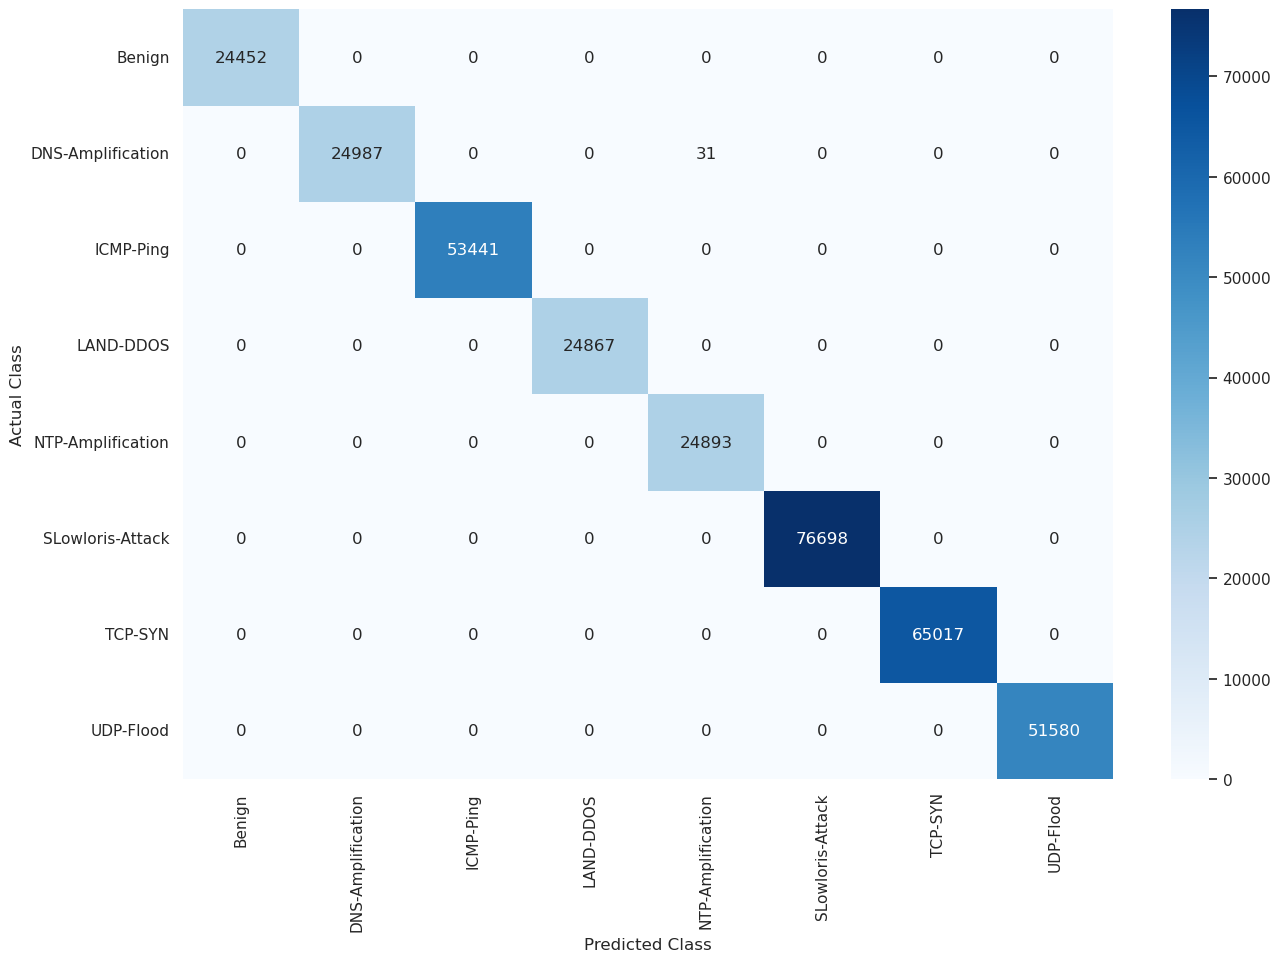

In [47]:

import time
import seaborn as sn

# Measure inference time
start_time = time.time()
pred = cnn.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)
cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cf_matrix)

labels = ['Benign','DNS-Amplification','ICMP-Ping','LAND-DDOS','NTP-Amplification','SLowloris-Attack','TCP-SYN','UDP-Flood']

#plt.figure(figsize=(20,15))
#sn.set(font_scale=1.4)
sn.set(rc = {'figure.figsize':(15,10)})
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show()  

In [58]:
import psutil
import time
import os

# Measure CPU and RAM usage before prediction
start_cpu_usagecnn = psutil.cpu_percent(interval=None)
start_processcnn = psutil.Process(os.getpid())
start_memory_usagecnn = start_processcnn.memory_info().rss / (1024 * 1024)  # Convert to MB


# Start prediction timer
start_timecnn = time.time()

# Make predictions
cnnR = cnn.predict(X_test)

# Stop prediction timer
end_timecnn = time.time()

# Measure CPU and RAM usage after prediction
end_cpu_usagecnn = psutil.cpu_percent(interval=None)
end_processcnn = psutil.Process(os.getpid())
end_memory_usagecnn = end_processcnn.memory_info().rss / (1024 * 1024)  # Convert to MB


# Calculate usage differences
cpu_usage_changecnn = end_cpu_usagecnn - start_cpu_usagecnn
memory_usage_changecnn = end_memory_usagecnn - start_memory_usagecnn

# Print results
print(f"Prediction time: {end_timecnn - start_timecnn:.4f} seconds")
print(f"CPU usage change: {cpu_usage_changecnn:.2f} %")
print(f"RAM usage change: {memory_usage_changecnn:.2f} MB")

10812/10812 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step
Prediction time: 37.4907 seconds
CPU usage change: 4.60 %
RAM usage change: 20.64 MB


10812/10812 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step


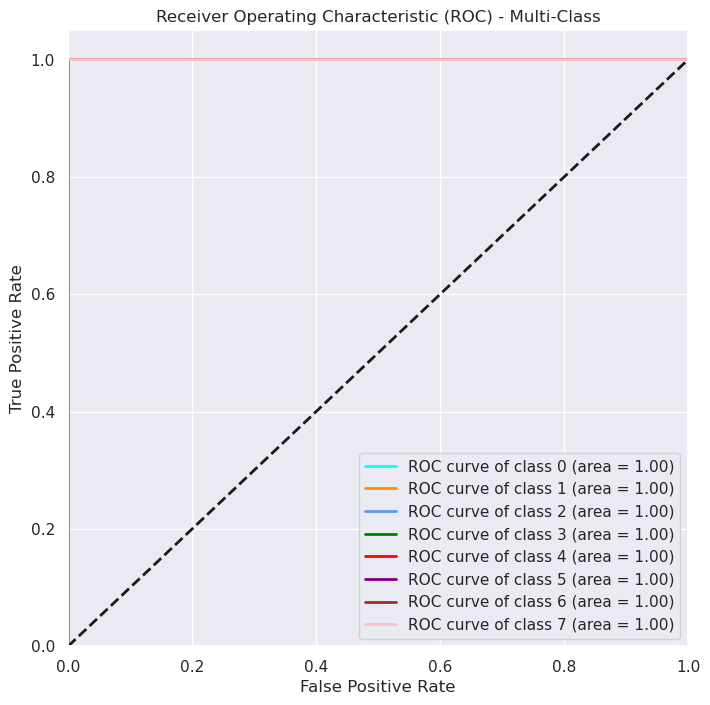

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Assuming 'pred' is your model's predicted probabilities and has a shape of (345966, 8)
pred = cnn.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = 8  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate dummies once
y_test_dummies = pd.get_dummies(y_eval, drop_first=False).values
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()


Epoch 1/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 93s 11ms/step - accuracy: 0.9872 - loss: 0.1253 - val_accuracy: 0.9997 - val_loss: 0.0768
Epoch 2/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 88s 11ms/step - accuracy: 0.9962 - loss: 0.0822 - val_accuracy: 0.9996 - val_loss: 0.0586
Epoch 3/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 88s 11ms/step - accuracy: 0.9969 - loss: 0.0776 - val_accuracy: 0.9996 - val_loss: 0.0600
Epoch 4/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 88s 11ms/step - accuracy: 0.9968 - loss: 0.0769 - val_accuracy: 0.9985 - val_loss: 0.0820
10812/10812 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9985 - loss: 0.0821

Test Loss: 0.0819573700428009
Test Accuracy: 0.998496949672699


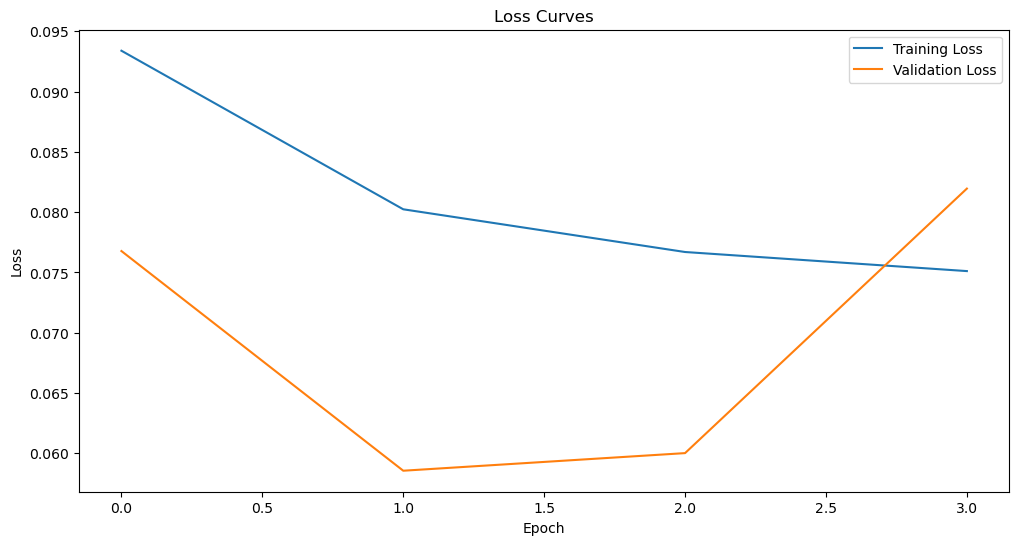

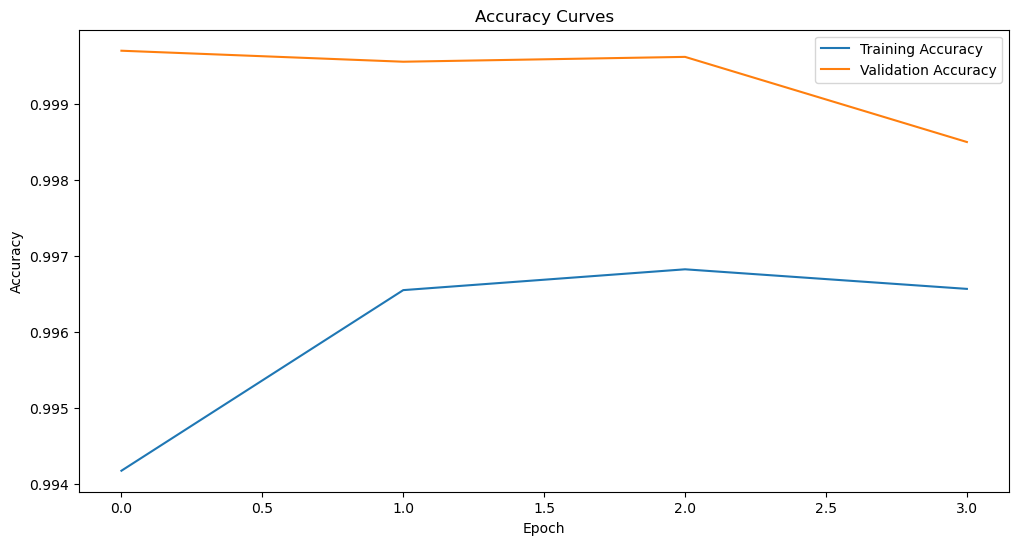

In [31]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Define the best hyperparameters
best_hyperparameters = {
    'lstm_units_1': 96,
    'l2_1': 0.0016168723737071179,
    'lstm_units_2': 96,
    'l2_2': 4.817500452374327e-06,
    'lstm_units_3': 128,
    'l2_3': 2.557674796721216e-06,
    'dense_1_units': 64,
    'l2_dense_1': 9.406669398810592e-06,
    'dropout_1': 0.5,
    'dense_2_units': 224,
    'l2_dense_2': 0.0044082252176780344,
    'dropout_2': 0.5,
    'learning_rate': 0.004224524015027432,
    'batch_size': 128
}
early_stop_callback = EarlyStopping(monitor='val_accuracy', patience=3)  # Customize settings as needed
# Reshape input data for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model using the best hyperparameters
LSTMmodel = keras.Sequential()

# LSTM layers with Batch Normalization
LSTMmodel.add(layers.LSTM(units=best_hyperparameters['lstm_units_1'],
                        input_shape=(1, _features),
                        kernel_regularizer=regularizers.l2(best_hyperparameters['l2_1']),
                        return_sequences=True))  # Changed here to return sequences

LSTMmodel.add(layers.LSTM(units=best_hyperparameters['lstm_units_2'],
                        kernel_regularizer=regularizers.l2(best_hyperparameters['l2_2']),
                        return_sequences=True))  # Changed here to return sequences

LSTMmodel.add(layers.LSTM(units=best_hyperparameters['lstm_units_3'],
                        kernel_regularizer=regularizers.l2(best_hyperparameters['l2_3']),
                        return_sequences=True))  # Changed here to return sequences

# Flatten layer
LSTMmodel.add(layers.Flatten())

# Dense layers with Batch Normalization
LSTMmodel.add(layers.Dense(units=best_hyperparameters['dense_1_units'],
                       kernel_regularizer=regularizers.l2(best_hyperparameters['l2_dense_1'])))
LSTMmodel.add(layers.BatchNormalization())
LSTMmodel.add(layers.Activation('relu'))
LSTMmodel.add(layers.Dropout(best_hyperparameters['dropout_1']))

LSTMmodel.add(layers.Dense(units=best_hyperparameters['dense_2_units'],
                       kernel_regularizer=regularizers.l2(best_hyperparameters['l2_dense_2'])))
LSTMmodel.add(layers.BatchNormalization())
LSTMmodel.add(layers.Activation('relu'))
LSTMmodel.add(layers.Dropout(best_hyperparameters['dropout_2']))

# Output layer
LSTMmodel.add(layers.Dense(n_classes, activation='softmax'))

# Optimizer
opt = keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate'])

# Compile the model
LSTMmodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = LSTMmodel.fit(X_train_reshaped, Y_train, epochs=15, batch_size=best_hyperparameters['batch_size'], 
                          validation_data=(X_test_reshaped, Y_test), callbacks=[early_stop_callback])
test_loss, test_accuracy = LSTMmodel.evaluate(X_test_reshaped, Y_test)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
from keras.models import load_model
LSTMmodel.save("LSTMSFINALV3.h5")

In [35]:
LSTMmodel.save("LSTMSFINALVersion.h5")

In [36]:
LSTMmodel.save("LSTMSFINALVersion.keras")

In [42]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import numpy as np
from keras.models import load_model

start = dt.datetime.now()

# Load the saved model
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
# Assuming X_test and Y_test are already defined
escore = LSTMmodel.evaluate(X_test_reshaped, Y_test, batch_size=128)
pred = LSTMmodel.predict(X_test_reshaped)
pred_classes = np.argmax(pred, axis=1)
y_eval = np.argmax(Y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_eval, pred_classes)

# Compute TP, TN, FP, FN for each class individually
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR) for each class
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# If you want overall FPR and FNR, you can average these values over all classes
overall_FPR = np.mean(FPR)
overall_FNR = np.mean(FNR)

score = accuracy_score(y_eval, pred_classes)
rscore = recall_score(y_eval, pred_classes, average='weighted')
ascore = precision_score(y_eval, pred_classes, average='weighted')
f1score = f1_score(y_eval, pred_classes, average='weighted')
roc_score = roc_auc_score(y_eval, pred, multi_class='ovo')

print('Completed')
print('Time taken:', dt.datetime.now()-start)
print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))
print("Overall False Positive Rate:", overall_FPR)
print("Overall False Negative Rate:", overall_FNR)


2703/2703 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9985 - loss: 0.0821
10812/10812 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step
Completed
Time taken: 0:00:47.278365
Validation score: 0.9984969621292266
Evaluation score: [0.08195780217647552, 0.998496949672699]
Recall score: 0.9984969621292266
Precision score: 0.9985275391603904
F1 Measure score: 0.9984968391382983
ROC-AUC score: 0.9999605361285026
Overall False Positive Rate: 0.0002024463243059957
Overall False Negative Rate: 0.002598245000553634


10812/10812 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step
Inference time: 34.11 seconds


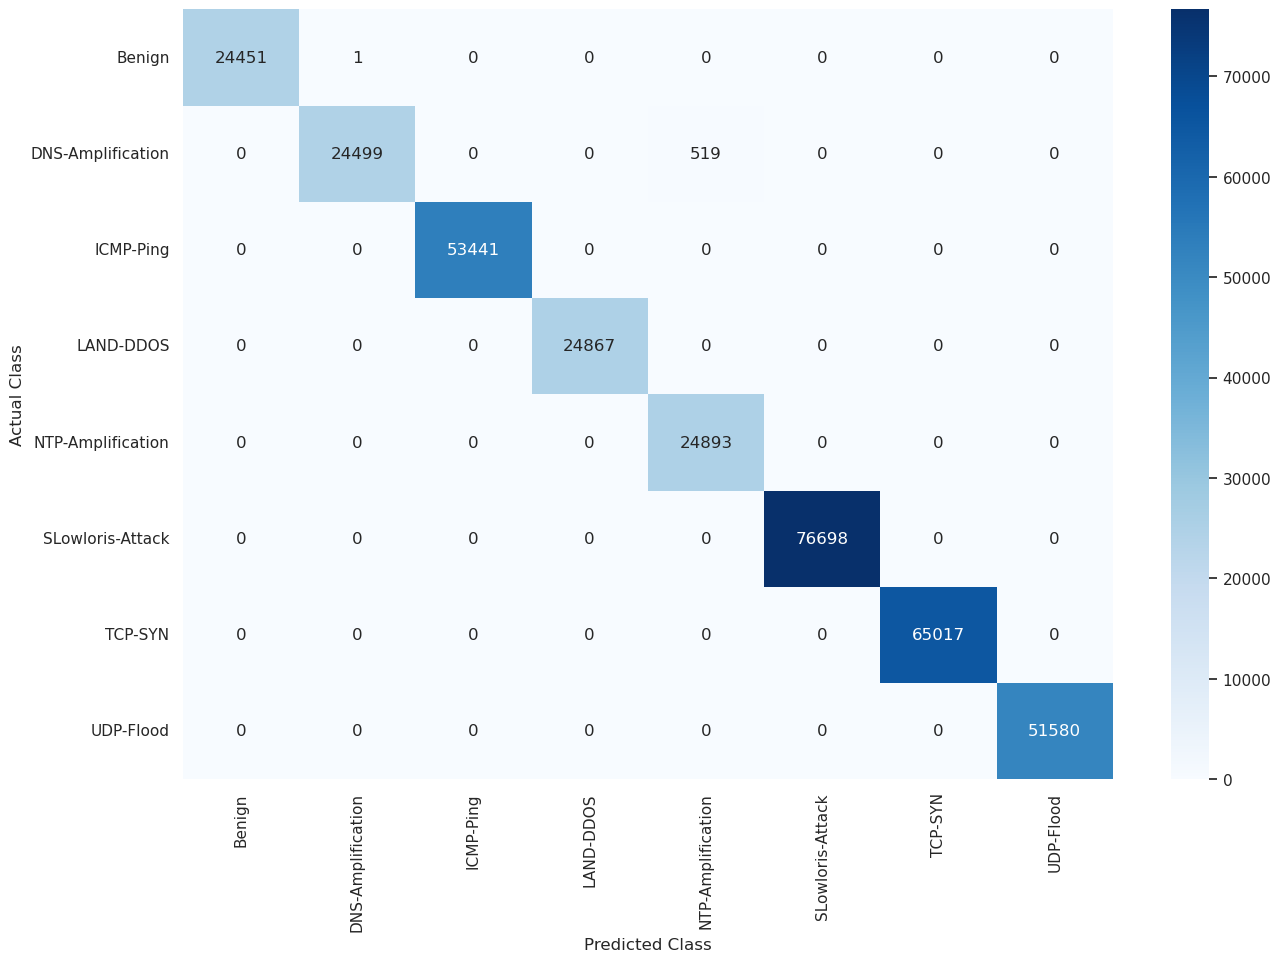

In [48]:

import time
import seaborn as sn

# Measure inference time
start_time = time.time()
pred = LSTMmodel.predict(X_test_reshaped)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)
cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cf_matrix)

labels = ['Benign','DNS-Amplification','ICMP-Ping','LAND-DDOS','NTP-Amplification','SLowloris-Attack','TCP-SYN','UDP-Flood']

#plt.figure(figsize=(20,15))
#sn.set(font_scale=1.4)
sn.set(rc = {'figure.figsize':(15,10)})
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show()  

In [57]:
import psutil
import time
import os

# Measure CPU and RAM usage before prediction
start_cpu_usagelstm = psutil.cpu_percent(interval=None)
start_processlstm = psutil.Process(os.getpid())
start_memory_usagelstm = start_processlstm.memory_info().rss / (1024 * 1024)  # Convert to MB


# Start prediction timer
start_timelstm = time.time()

# Make predictions
lstmR = LSTMmodel.predict(X_test_reshaped)

# Stop prediction timer
end_timelstm = time.time()

# Measure CPU and RAM usage after prediction
end_cpu_usagelstm = psutil.cpu_percent(interval=None)
end_processlstm = psutil.Process(os.getpid())
end_memory_usagelstm = end_processlstm.memory_info().rss / (1024 * 1024)  # Convert to MB


# Calculate usage differences
cpu_usage_changelstm = end_cpu_usagelstm - start_cpu_usagelstm
memory_usage_changelstm = end_memory_usagelstm - start_memory_usagelstm

# Print results
print(f"Prediction time: {end_timelstm - start_timelstm:.4f} seconds")
print(f"CPU usage change: {cpu_usage_changelstm:.2f} %")
print(f"RAM usage change: {memory_usage_changelstm:.2f} MB")

10812/10812 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step
Prediction time: 34.1492 seconds
CPU usage change: 3.40 %
RAM usage change: 21.68 MB


10812/10812 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step


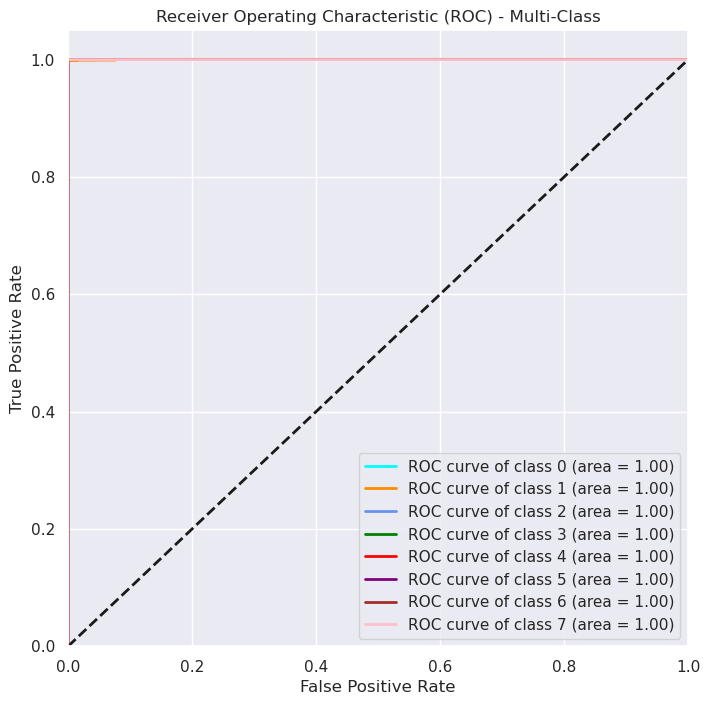

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Assuming 'pred' is your model's predicted probabilities and has a shape of (345966, 8)
pred = LSTMmodel.predict(X_test_reshaped)

# Compute ROC curve and ROC area for each class
n_classes = 8  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate dummies once
y_test_dummies = pd.get_dummies(y_eval, drop_first=False).values
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()


Epoch 1/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 919s 113ms/step - accuracy: 0.9786 - loss: 0.1356 - val_accuracy: 1.0000 - val_loss: 0.0521
Epoch 2/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 912s 112ms/step - accuracy: 0.9967 - loss: 0.0745 - val_accuracy: 1.0000 - val_loss: 0.0508
Epoch 3/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 911s 112ms/step - accuracy: 0.9972 - loss: 0.0691 - val_accuracy: 1.0000 - val_loss: 0.0723
Epoch 4/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 914s 113ms/step - accuracy: 0.9971 - loss: 0.0757 - val_accuracy: 0.9422 - val_loss: 0.4613
10812/10812 ━━━━━━━━━━━━━━━━━━━━ 185s 17ms/step - accuracy: 0.9416 - loss: 0.4652

Test Loss: 0.4613296687602997
Test Accuracy: 0.9421995282173157


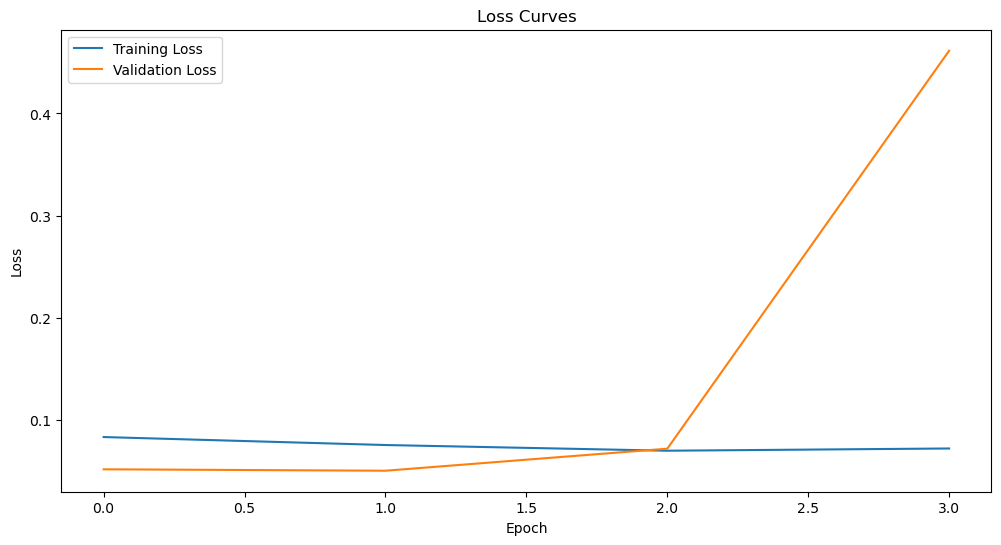

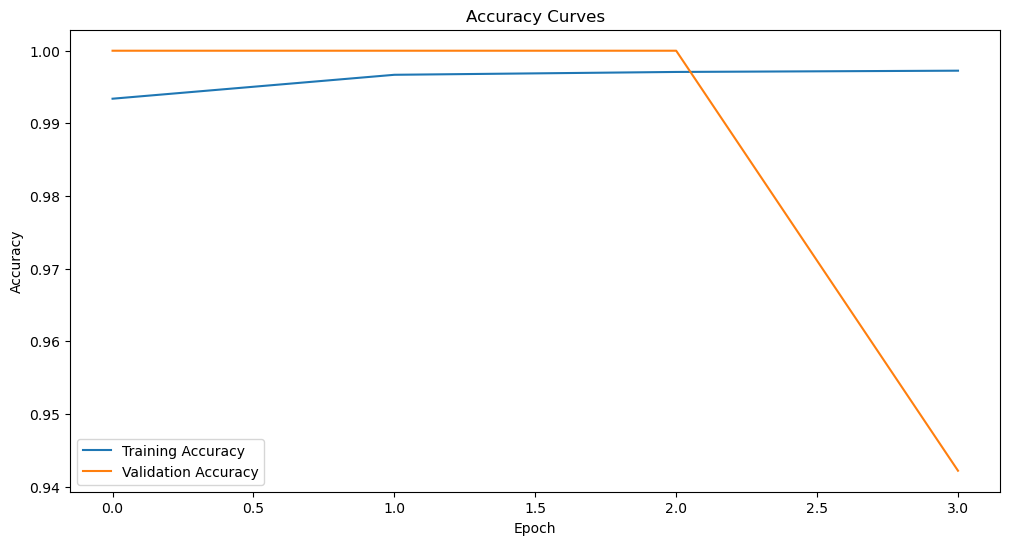

In [32]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the best hyperparameters
best_hyperparameters = {
    'gru_1_units': 96,
    'l2_1': 0.0016168723737071179,
    'gru_2_units': 96,
    'l2_2': 4.817500452374327e-06,
    'gru_3_units': 128,
    'l2_3': 2.557674796721216e-06,
    'dense_1_units': 64,
    'l2_dense_1': 9.406669398810592e-06,
    'dropout_1': 0.5,
    'dense_2_units': 224,
    'l2_dense_2': 0.0044082252176780344,
    'dropout_2': 0.5,
    'learning_rate': 0.004224524015027432,
    'batch_size': 128
}
early_stop_callback = EarlyStopping(monitor='val_accuracy', patience=3)  # Customize settings as needed

# Build the model using the best hyperparameters
gru = keras.Sequential()

# GRU layers with Batch Normalization
gru.add(layers.GRU(units=best_hyperparameters['gru_1_units'],
                   input_shape=(_features, 1),
                   kernel_regularizer=regularizers.l2(best_hyperparameters['l2_1']),
                   return_sequences=True))
gru.add(layers.BatchNormalization())
gru.add(layers.Activation('relu'))

gru.add(layers.GRU(units=best_hyperparameters['gru_2_units'],
                   kernel_regularizer=regularizers.l2(best_hyperparameters['l2_2']),
                   return_sequences=True))
gru.add(layers.BatchNormalization())
gru.add(layers.Activation('relu'))

gru.add(layers.GRU(units=best_hyperparameters['gru_3_units'],
                   kernel_regularizer=regularizers.l2(best_hyperparameters['l2_3']),
                   return_sequences=False))
gru.add(layers.BatchNormalization())
gru.add(layers.Activation('relu'))

# Dense layers with Batch Normalization
gru.add(layers.Dense(units=best_hyperparameters['dense_1_units'],
                     kernel_regularizer=regularizers.l2(best_hyperparameters['l2_dense_1'])))
gru.add(layers.BatchNormalization())
gru.add(layers.Activation('relu'))
gru.add(layers.Dropout(best_hyperparameters['dropout_1']))

gru.add(layers.Dense(units=best_hyperparameters['dense_2_units'],
                     kernel_regularizer=regularizers.l2(best_hyperparameters['l2_dense_2'])))
gru.add(layers.BatchNormalization())
gru.add(layers.Activation('relu'))
gru.add(layers.Dropout(best_hyperparameters['dropout_2']))

# Output layer
gru.add(layers.Dense(n_classes, activation='softmax'))

# Optimizer
opt = keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate'])

# Compile the model
gru.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = gru.fit(X_train, Y_train, epochs=15, batch_size=best_hyperparameters['batch_size'], 
                          validation_data=(X_test, Y_test), callbacks=[early_stop_callback])
test_loss, test_accuracy = gru.evaluate(X_test, Y_test)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [33]:
gru.save("GRUFINALVersion.h5")

In [34]:
gru.save("GRUFINALVersion.keras")

In [43]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import numpy as np
from keras.models import load_model

start = dt.datetime.now()

# Load the saved model
# Assuming X_test and Y_test are already defined
escore = gru.evaluate(X_test, Y_test, batch_size=128)
pred = gru.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_eval = np.argmax(Y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_eval, pred_classes)

# Compute TP, TN, FP, FN for each class individually
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR) for each class
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# If you want overall FPR and FNR, you can average these values over all classes
overall_FPR = np.mean(FPR)
overall_FNR = np.mean(FNR)

score = accuracy_score(y_eval, pred_classes)
rscore = recall_score(y_eval, pred_classes, average='weighted')
ascore = precision_score(y_eval, pred_classes, average='weighted')
f1score = f1_score(y_eval, pred_classes, average='weighted')
roc_score = roc_auc_score(y_eval, pred, multi_class='ovo')

print('Completed')
print('Time taken:', dt.datetime.now()-start)
print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))
print("Overall False Positive Rate:", overall_FPR)
print("Overall False Negative Rate:", overall_FNR)

2703/2703 ━━━━━━━━━━━━━━━━━━━━ 93s 34ms/step - accuracy: 0.9416 - loss: 0.4652
10812/10812 ━━━━━━━━━━━━━━━━━━━━ 182s 17ms/step
Completed
Time taken: 0:04:40.255889
Validation score: 0.9421995224964302
Evaluation score: [0.461340069770813, 0.9421995282173157]
Recall score: 0.9421995224964302
Precision score: 0.9593449422396848
F1 Measure score: 0.9363326198989794
ROC-AUC score: 0.9887077619736523
Overall False Positive Rate: 0.00793208852461363
Overall False Negative Rate: 0.09999620885182972


10812/10812 ━━━━━━━━━━━━━━━━━━━━ 179s 17ms/step
Inference time: 183.91 seconds


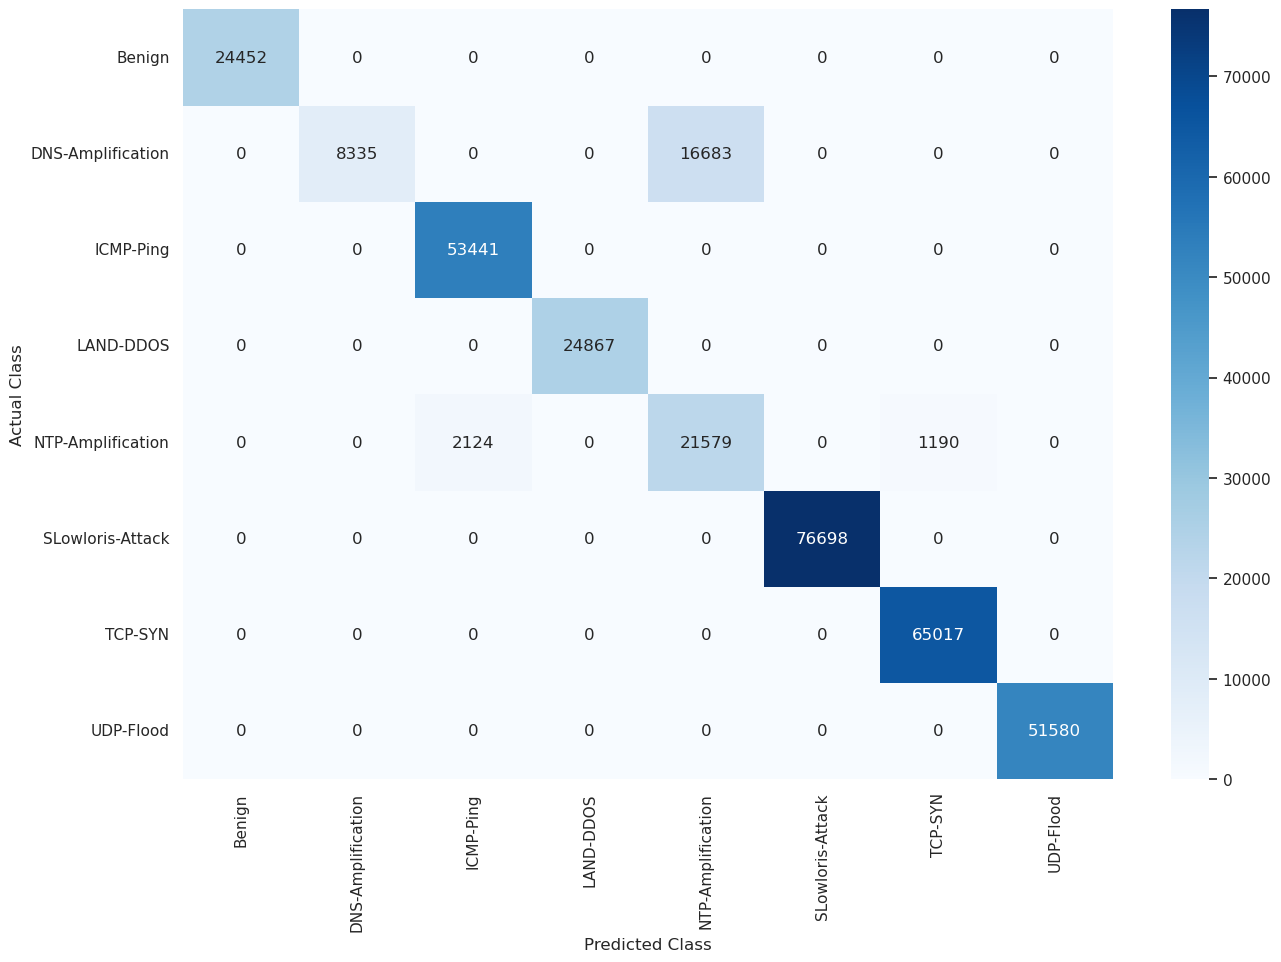

In [49]:

import time
import seaborn as sn

# Measure inference time
start_time = time.time()
pred = gru.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)
cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cf_matrix)

labels = ['Benign','DNS-Amplification','ICMP-Ping','LAND-DDOS','NTP-Amplification','SLowloris-Attack','TCP-SYN','UDP-Flood']

#plt.figure(figsize=(20,15))
#sn.set(font_scale=1.4)
sn.set(rc = {'figure.figsize':(15,10)})
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show()  

10812/10812 ━━━━━━━━━━━━━━━━━━━━ 180s 17ms/step


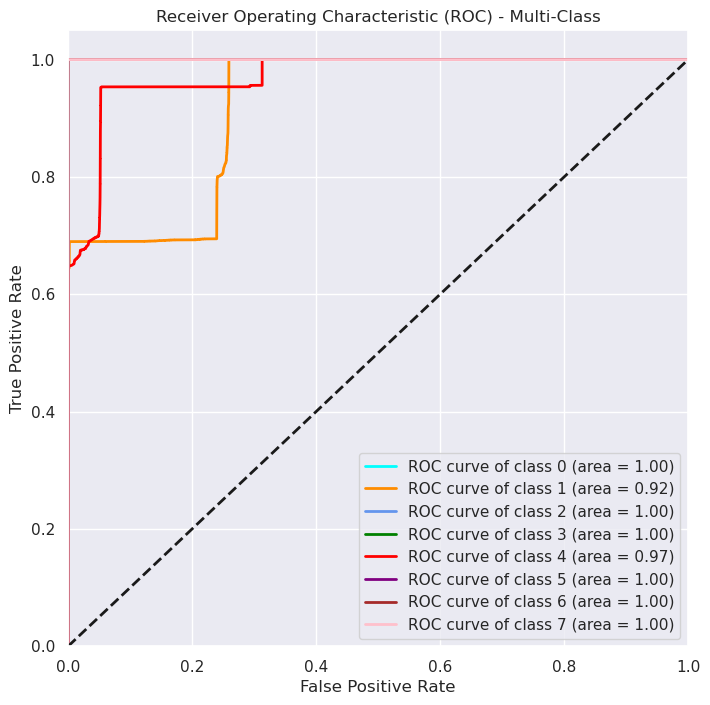

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Assuming 'pred' is your model's predicted probabilities and has a shape of (345966, 8)
pred = gru.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = 8  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate dummies once
y_test_dummies = pd.get_dummies(y_eval, drop_first=False).values
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve

# Example for one class
fpr, tpr, thresholds = roc_curve(Y_test_binarized[:, 0], pred[:, 0])

for t, f, r in zip(thresholds, fpr, tpr):
    print(f'Threshold: {t:.2f}, FPR: {f:.2f}, TPR: {r:.2f}')


In [59]:
import psutil
import time
import os

# Measure CPU and RAM usage before prediction
start_cpu_usagegru = psutil.cpu_percent(interval=None)
start_processgru = psutil.Process(os.getpid())
start_memory_usagegru = start_processgru.memory_info().rss / (1024 * 1024)  # Convert to MB


# Start prediction timer
start_timegru = time.time()

# Make predictions
gruR = gru.predict(X_test)

# Stop prediction timer
end_timegru = time.time()

# Measure CPU and RAM usage after prediction
end_cpu_usagegru = psutil.cpu_percent(interval=None)
end_processgru = psutil.Process(os.getpid())
end_memory_usagegru = end_processgru.memory_info().rss / (1024 * 1024)  # Convert to MB


# Calculate usage differences
cpu_usage_changegru = end_cpu_usagegru - start_cpu_usagegru
memory_usage_changegru = end_memory_usagegru - start_memory_usagegru

# Print results
print(f"Prediction time: {end_timegru - start_timegru:.4f} seconds")
print(f"CPU usage change: {cpu_usage_changegru:.2f} %")
print(f"RAM usage change: {memory_usage_changegru:.2f} MB")

10812/10812 ━━━━━━━━━━━━━━━━━━━━ 181s 17ms/step
Prediction time: 185.7246 seconds
CPU usage change: 5.60 %
RAM usage change: 19.46 MB


Epoch 1/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 177s 21ms/step - accuracy: 0.9894 - loss: 0.1535 - val_accuracy: 0.9981 - val_loss: 0.1057
Epoch 2/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 169s 21ms/step - accuracy: 0.9965 - loss: 0.0859 - val_accuracy: 0.9997 - val_loss: 0.0619
Epoch 3/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 167s 21ms/step - accuracy: 0.9969 - loss: 0.0799 - val_accuracy: 0.9999 - val_loss: 0.0603
Epoch 4/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 167s 21ms/step - accuracy: 0.9971 - loss: 0.0716 - val_accuracy: 0.9997 - val_loss: 0.0585
Epoch 5/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 167s 21ms/step - accuracy: 0.9969 - loss: 0.0716 - val_accuracy: 0.9998 - val_loss: 0.0519
Epoch 6/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 167s 21ms/step - accuracy: 0.9971 - loss: 0.0664 - val_accuracy: 1.0000 - val_loss: 0.0504
Epoch 7/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 167s 21ms/step - accuracy: 0.9973 - loss: 0.0651 - val_accuracy: 0.9996 - val_loss: 0.0472
Epoch 8/15
8109/8109 ━━━━━━━━━━━━━━━━━━━━ 167s 21ms/step - accuracy: 

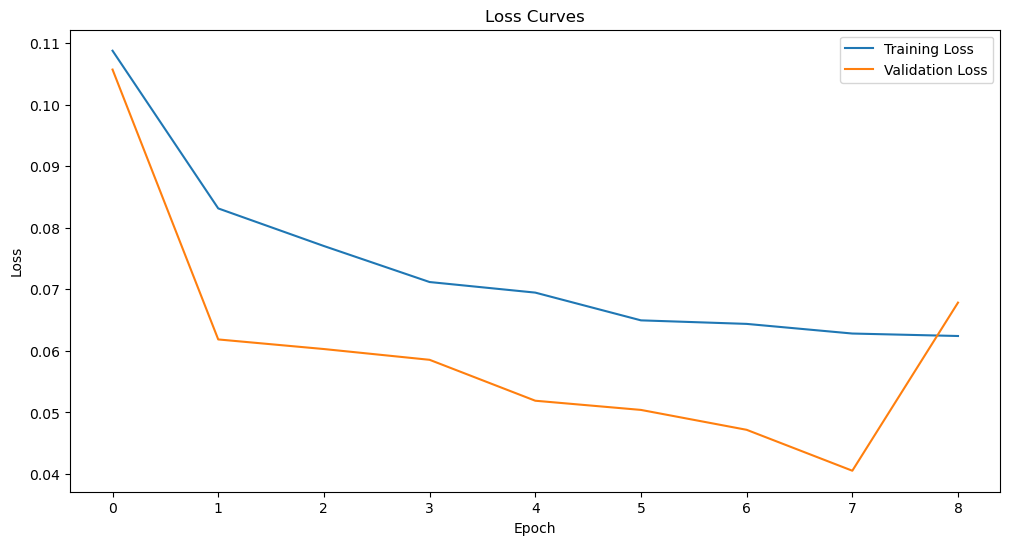

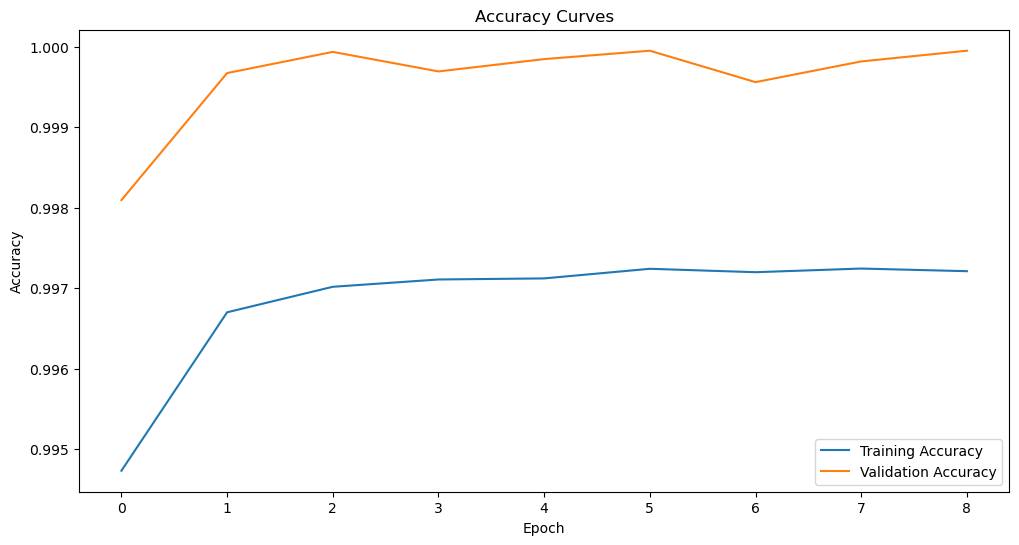

In [26]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the best hyperparameters
best_hyperparameters = {
    'conv1d_1_filters': 96,
    'l2_1': 0.0016168723737071179,
    'conv1d_2_filters': 96,
    'l2_2': 4.817500452374327e-06,
    'conv1d_3_filters': 128,
    'l2_3': 2.557674796721216e-06,
    'bilstm_units': 64, # You can change this value
    'l2_bilstm': 0.001, # You can change this value
    'dense_1_units': 64,
    'l2_dense_1': 9.406669398810592e-06,
    'dropout_1': 0.5,
    'dense_2_units': 224,
    'l2_dense_2': 0.0044082252176780344,
    'dropout_2': 0.5,
    'learning_rate': 0.004224524015027432,
    'batch_size': 128
}
early_stop_callback = EarlyStopping(monitor='val_accuracy', patience=3)  # Customize settings as needed

# Build the model using the best hyperparameters
cnn_bilstm = keras.Sequential()

# Convolutional layers with Batch Normalization
cnn_bilstm.add(layers.Conv1D(filters=best_hyperparameters['conv1d_1_filters'],
                        kernel_size=6,
                        input_shape=(_features, 1),
                        kernel_regularizer=regularizers.l2(best_hyperparameters['l2_1'])))
cnn_bilstm.add(layers.BatchNormalization())
cnn_bilstm.add(layers.Activation('relu'))
cnn_bilstm.add(layers.MaxPooling1D(pool_size=2))

cnn_bilstm.add(layers.Conv1D(filters=best_hyperparameters['conv1d_2_filters'],
                        kernel_size=6,
                        padding='same',
                        kernel_regularizer=regularizers.l2(best_hyperparameters['l2_2'])))
cnn_bilstm.add(layers.BatchNormalization())
cnn_bilstm.add(layers.Activation('relu'))
cnn_bilstm.add(layers.MaxPooling1D(pool_size=2))

cnn_bilstm.add(layers.Conv1D(filters=best_hyperparameters['conv1d_3_filters'],
                        kernel_size=6,
                        padding='same',
                        kernel_regularizer=regularizers.l2(best_hyperparameters['l2_3'])))
cnn_bilstm.add(layers.BatchNormalization())
cnn_bilstm.add(layers.Activation('relu'))
cnn_bilstm.add(layers.MaxPooling1D(pool_size=2))

# Bidirectional LSTM layer with Batch Normalization
cnn_bilstm.add(layers.Bidirectional(layers.LSTM(units=best_hyperparameters['bilstm_units'],
                                                 kernel_regularizer=regularizers.l2(best_hyperparameters['l2_bilstm']),
                                                 return_sequences=False)))
cnn_bilstm.add(layers.BatchNormalization())
cnn_bilstm.add(layers.Activation('relu'))

# Dense layers with Batch Normalization
cnn_bilstm.add(layers.Dense(units=best_hyperparameters['dense_1_units'],
                       kernel_regularizer=regularizers.l2(best_hyperparameters['l2_dense_1'])))
cnn_bilstm.add(layers.BatchNormalization())
cnn_bilstm.add(layers.Activation('relu'))
cnn_bilstm.add(layers.Dropout(best_hyperparameters['dropout_1']))

cnn_bilstm.add(layers.Dense(units=best_hyperparameters['dense_2_units'],
                       kernel_regularizer=regularizers.l2(best_hyperparameters['l2_dense_2'])))
cnn_bilstm.add(layers.BatchNormalization())
cnn_bilstm.add(layers.Activation('relu'))
cnn_bilstm.add(layers.Dropout(best_hyperparameters['dropout_2']))

# Output layer
cnn_bilstm.add(layers.Dense(n_classes, activation='softmax'))

# Optimizer
opt = keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate'])

# Compile the model
cnn_bilstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = cnn_bilstm.fit(X_train, Y_train, epochs=15, batch_size=best_hyperparameters['batch_size'], 
                          validation_data=(X_test, Y_test), callbacks=[early_stop_callback])
test_loss, test_accuracy = cnn_bilstm.evaluate(X_test, Y_test)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [40]:
cnn_bilstm.save("CNNBILSTMFINALVersions.h5")

In [45]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import numpy as np

start = dt.datetime.now()

escore = cnn_bilstm.evaluate(X_test, Y_test, batch_size=128)
pred = cnn_bilstm.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_eval = np.argmax(Y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_eval, pred_classes)

# Compute TP, TN, FP, FN for each class individually
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR) for each class
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# If you want overall FPR and FNR, you can average these values over all classes
overall_FPR = np.mean(FPR)
overall_FNR = np.mean(FNR)

score = accuracy_score(y_eval, pred_classes)
rscore = recall_score(y_eval, pred_classes, average='weighted')
ascore = precision_score(y_eval, pred_classes, average='weighted')
f1score = f1_score(y_eval, pred_classes, average='weighted')
roc_score = roc_auc_score(y_eval, pred, multi_class='ovo')

print('Completed')
print('Time taken:', dt.datetime.now()-start)
print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))
print("Overall False Positive Rate:", overall_FPR)
print("Overall False Negative Rate:", overall_FNR)


2703/2703 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 1.0000 - loss: 0.0678
10812/10812 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Completed
Time taken: 0:01:04.434809
Validation score: 0.9999508622234555
Evaluation score: [0.06783060729503632, 0.9999508857727051]
Recall score: 0.9999508622234555
Precision score: 0.9999508957578673
F1 Measure score: 0.9999508622596712
ROC-AUC score: 0.9999999670253658
Overall False Positive Rate: 6.6184325682944376e-06
Overall False Negative Rate: 8.493884403229675e-05


10812/10812 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Inference time: 46.32 seconds


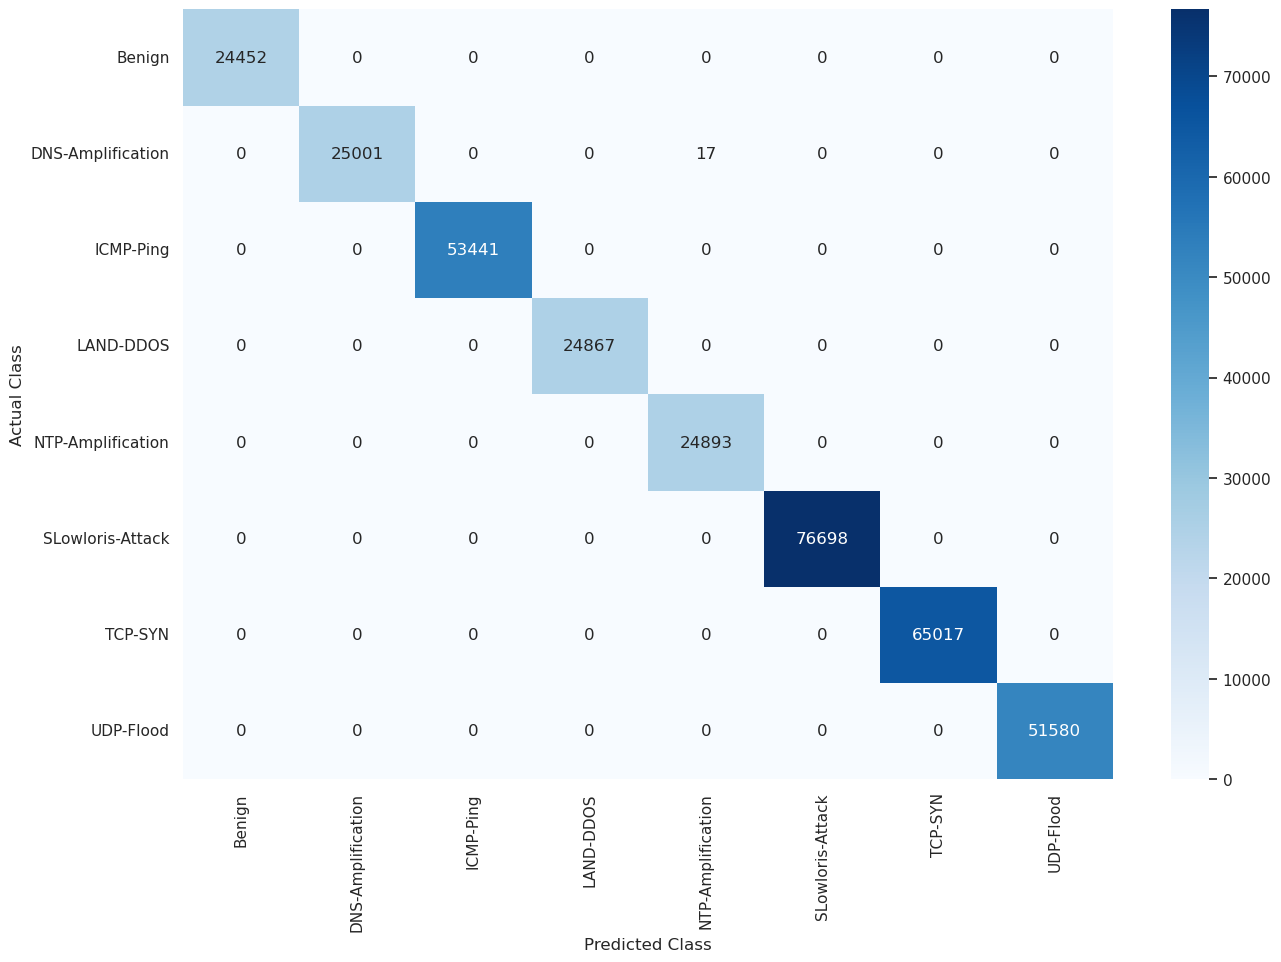

In [50]:

import time
import seaborn as sn

# Measure inference time
start_time = time.time()
pred = cnn_bilstm.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)
cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cf_matrix)

labels = ['Benign','DNS-Amplification','ICMP-Ping','LAND-DDOS','NTP-Amplification','SLowloris-Attack','TCP-SYN','UDP-Flood']

#plt.figure(figsize=(20,15))
#sn.set(font_scale=1.4)
sn.set(rc = {'figure.figsize':(15,10)})
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show()  

10812/10812 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step


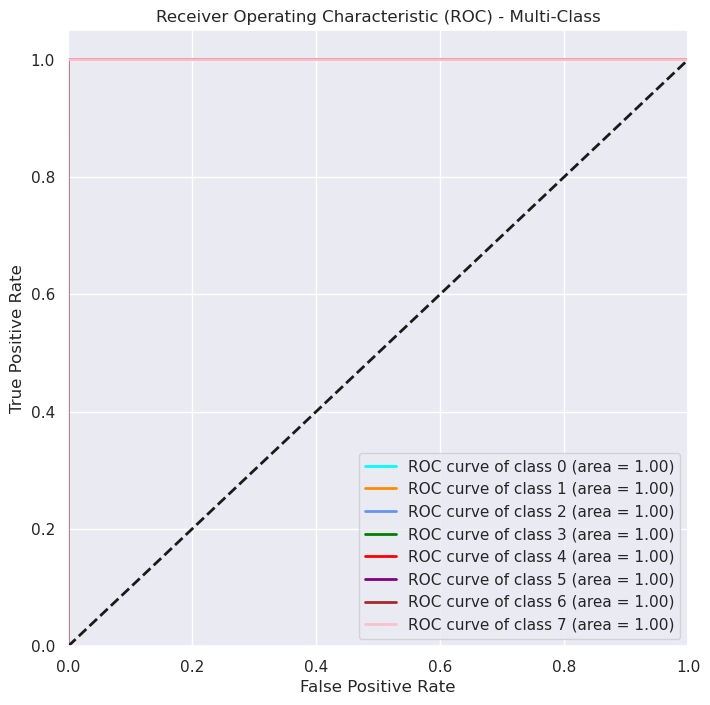

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Assuming 'pred' is your model's predicted probabilities and has a shape of (345966, 8)
pred = cnn_bilstm.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = 8  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate dummies once
y_test_dummies = pd.get_dummies(y_eval, drop_first=False).values
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [75]:
print(pred.shape)


(345966,)


In [73]:
for i in range(n_classes):  # n_classes should be 8 in your case
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], pred[:, i])
    
    roc_auc[i] = auc(fpr[i], tpr[i])
print('Shape of Y_test_binarized:', Y_test_binarized.shape)
print('Shape of pred:', pred.shape)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [60]:
import psutil
import time
import os

# Measure CPU and RAM usage before prediction
start_cpu_usagecnn_bilstm = psutil.cpu_percent(interval=None)
start_processcnn_bilstm = psutil.Process(os.getpid())
start_memory_usagecnn_bilstm = start_processcnn_bilstm.memory_info().rss / (1024 * 1024)  # Convert to MB


# Start prediction timer
start_timecnn_bilstm = time.time()

# Make predictions
cnn_bilstmR = cnn_bilstm.predict(X_test)

# Stop prediction timer
end_timecnn_bilstm = time.time()

# Measure CPU and RAM usage after prediction
end_cpu_usagecnn_bilstm = psutil.cpu_percent(interval=None)
end_processcnn_bilstm = psutil.Process(os.getpid())
end_memory_usagecnn_bilstm = end_processcnn_bilstm.memory_info().rss / (1024 * 1024)  # Convert to MB


# Calculate usage differences
cpu_usage_changecnn_bilstm = end_cpu_usagecnn_bilstm - start_cpu_usagecnn_bilstm
memory_usage_changecnn_bilstm = end_memory_usagecnn_bilstm - start_memory_usagecnn_bilstm

# Print results
print(f"Prediction time: {end_timecnn_bilstm - start_timecnn_bilstm:.4f} seconds")
print(f"CPU usage change: {cpu_usage_changecnn_bilstm:.2f} %")
print(f"RAM usage change: {memory_usage_changecnn_bilstm:.2f} MB")

10812/10812 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Prediction time: 46.4381 seconds
CPU usage change: 5.10 %
RAM usage change: 20.13 MB


In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

# Binarize the output labels for each class
Y_test_binarized = label_binarize(y_eval, classes=np.unique(y_eval))

# Compute ROC curve and ROC area for each class
n_classes = Y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_binarized.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for the multi-class problem
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure()

colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import numpy as np
from keras.models import load_model

start = dt.datetime.now()

# Load the saved model
# Assuming X_test and Y_test are already defined
escore = cnn_bilstm.evaluate(X_test, Y_test, batch_size=128)
pred = cnn_bilstm.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
y_eval = np.argmax(Y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_eval, pred_classes)

# Compute TP, TN, FP, FN for each class individually
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR) for each class
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# If you want overall FPR and FNR, you can average these values over all classes
overall_FPR = np.mean(FPR)
overall_FNR = np.mean(FNR)

score = accuracy_score(y_eval, pred_classes)
rscore = recall_score(y_eval, pred_classes, average='weighted')
ascore = precision_score(y_eval, pred_classes, average='weighted')
f1score = f1_score(y_eval, pred_classes, average='weighted')
roc_score = roc_auc_score(y_eval, pred, multi_class='ovo')

print('Completed')
print('Time taken:', dt.datetime.now()-start)
print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))
print("Overall False Positive Rate:", overall_FPR)
print("Overall False Negative Rate:", overall_FNR)

In [51]:
# Stage 2 Models Evaluation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score, precision_recall_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredLogarithmicError
np.random.seed(42)
tf.random.set_seed(42)
# Extract features (X) and labels (Y)
AX = data_np[:, 1:22]
Ay = data_np[:, -1]

# Filter benign data
X_benign_autoencoder = AX[Ay == 0]

# Split the benign data for training (90%) and testing (10%)
x_train_autoencoder, x_test_benign_autoencoder, _, _ = train_test_split(
    X_benign_autoencoder,
    np.zeros(X_benign_autoencoder.shape[0]),  # Labels are all zeros for benign data
    test_size=0.1,
    stratify=np.zeros(X_benign_autoencoder.shape[0]),
    random_state=42  # Set random state for reproducibility
)

# Randomly select 10,000 anomalous instances with labels from 1 to 7 for testing
X_anomalous_autoencoder_test = AX[(Ay >= 7)]
selected_anomalous_indices = np.random.choice(X_anomalous_autoencoder_test.shape[0], size=10000, replace=False)
X_anomalous_autoencoder_test = X_anomalous_autoencoder_test[selected_anomalous_indices, :]

# Labels: 1 for anomaly, 0 for normal
y_anomalous_autoencoder_test = np.ones(X_anomalous_autoencoder_test.shape[0])

# Combine the benign test data and anomalous test data
x_test_autoencoder = np.vstack([x_test_benign_autoencoder, X_anomalous_autoencoder_test])
y_test_autoencoder = np.concatenate([np.zeros(x_test_benign_autoencoder.shape[0]), y_anomalous_autoencoder_test])

# Scale the data using MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_autoencoder_scaled = min_max_scaler.fit_transform(x_train_autoencoder.copy())
x_test_autoencoder_scaled = min_max_scaler.transform(x_test_autoencoder.copy())

# Build the model with the best hyperparameters
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=x_train_autoencoder_scaled.shape[1]))
model.add(Dropout(rate=0.2))
model.add(Dense(units=96, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(x_train_autoencoder_scaled.shape[1], activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error')

# Fit the model to the entire training data
model.fit(x_train_autoencoder_scaled, x_train_autoencoder_scaled, epochs=30, batch_size=256, shuffle=True)

# Evaluate on the benign instances
mse_normal = MeanSquaredLogarithmicError()(x_test_benign_autoencoder, model.predict(x_test_benign_autoencoder))
threshold = mse_normal.numpy()

# Convert the reconstruction error to binary predictions (0: benign, 1: anomalous)
reconstruction_error = np.mean(np.square(x_test_autoencoder_scaled - model.predict(x_test_autoencoder_scaled)), axis=1)
y_pred = (reconstruction_error > threshold).astype(int)

# Evaluate performance metrics
accuracy = accuracy_score(y_test_autoencoder, y_pred)
conf_matrix = confusion_matrix(y_test_autoencoder, y_pred)
precision = precision_score(y_test_autoencoder, y_pred, average='weighted')
recall = recall_score(y_test_autoencoder, y_pred, average='weighted')
f1 = f1_score(y_test_autoencoder, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test_autoencoder, y_pred)
avg_precision = average_precision_score(y_test_autoencoder, y_pred)
mcc = matthews_corrcoef(y_test_autoencoder, y_pred)
kappa = cohen_kappa_score(y_test_autoencoder, y_pred)
balanced_acc = balanced_accuracy_score(y_test_autoencoder, y_pred)

precision_, recall_, _ = precision_recall_curve(y_test_autoencoder, y_pred)
pr_auc = auc(recall_, precision_)

# Print performance metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Confusion Matrix:\n", conf_matrix)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("ROC-AUC Score: {:.4f}".format(roc_auc))
print("Average Precision Score: {:.4f}".format(avg_precision))
print("Matthews Correlation Coefficient: {:.4f}".format(mcc))
print("Cohen's Kappa: {:.4f}".format(kappa))
print("Balanced Accuracy: {:.4f}".format(balanced_acc))
print("PR AUC: {:.4f}".format(pr_auc))
print("Best Hyperparameters:")


Epoch 1/30


/users/siru/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0893
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0261
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0144
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060
Epoch 7/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0052
Epoch 8/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046
Epoch 9/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042
Epoch 10/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039
Epoch 11/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036
Epoch 12/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034
Epoch 13/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032
Epoch 14/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030
Epoch 15/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029


In [52]:
model.save("Autoencoderfinalversion.h5")

In [53]:
model.save("Autoencoderfinalversion.keras")

In [85]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, z_mean, z_log_var, **kwargs):
        super(CustomVariationalLayer, self).__init__(**kwargs)
        self.z_mean = z_mean
        self.z_log_var = z_log_var

    def vae_loss(self, inputs):
        x = K.flatten(inputs[0])
        z_decoded = K.flatten(inputs[1])
        xent_loss = binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.sum(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        loss = self.vae_loss(inputs)
        self.add_loss(loss)
        return inputs[0]

# Encoder network
def build_encoder(original_dim, intermediate_dim, latent_dim):
    input_img = Input(shape=(original_dim,))
    hidden_1 = Dense(intermediate_dim, activation='relu')(input_img)
    z_mean = Dense(latent_dim)(hidden_1)
    z_log_var = Dense(latent_dim)(hidden_1)
    return input_img, hidden_1, z_mean, z_log_var

# Latent space sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Decoder network
def build_decoder(intermediate_dim, original_dim, latent_dim):
    latent_inputs = Input(shape=(latent_dim,))
    hidden_2 = Dense(intermediate_dim, activation='relu')(latent_inputs)
    decoded_outputs = Dense(original_dim, activation='sigmoid')(hidden_2)
    return latent_inputs, decoded_outputs

# VAE model assembly
def build_vae(original_dim, intermediate_dim, latent_dim):
    input_img, hidden_1, z_mean, z_log_var = build_encoder(original_dim, intermediate_dim, latent_dim)
    z = Lambda(sampling)([z_mean, z_log_var])
    latent_inputs, decoded_outputs = build_decoder(intermediate_dim, original_dim, latent_dim)
    decoder = Model(latent_inputs, decoded_outputs)
    z_decoded = decoder(z)
    vae = Model(input_img, CustomVariationalLayer([z_mean, z_log_var])([input_img, z_decoded]))
    vae.compile(optimizer='rmsprop', loss=None)
    return vae, decoder

# Define your data dimensions here
original_dim = # number of features in your network traffic data
intermediate_dim = # size of hidden layers, e.g., 64
latent_dim = # size of latent space, e.g., 2

# Load and preprocess your network traffic data
# x_train_autoencoder_scaled = # your preprocessed training data
# x_test_autoencoder_scaled = # your preprocessed test data

# Build the VAE
vae, decoder = build_vae(original_dim, intermediate_dim, latent_dim)

# Training
vae.fit(x_train_autoencoder_scaled, x_train_autoencoder_scaled,
        shuffle=True,
        epochs=50,  # adjust based on your needs
        batch_size=256,  # adjust based on your needs
        validation_data=(x_test_autoencoder_scaled, x_test_autoencoder_scaled))

# Encoder model to project inputs on the latent space
encoder = Model(input_img, z_mean)

# Display the mean squared error for the test set
x_test_encoded = encoder.predict(x_test_autoencoder_scaled, batch_size=256)
mse_test = np.mean(np.square(x_test_autoencoder_scaled - decoder.predict(x_test_encoded)), axis=-1)
print("Mean Squared Error on Test Set: {:.4f}".format(np.mean(mse_test)))


SyntaxError: invalid syntax (2982842630.py, line 64)